In [1]:
#FUNCTIONS
import numpy as np
def data(frame, hdul):# Getting Flux Data
    return hdul[1].data['FLUX'][frame]
def get_time(frame, hdul):# Getting Time data
    return hdul[1].data['TIME'][frame]
def fillna(arr):# Used to fill na values # Not relevant for this program
    for i in range(len(arr)):
        if np.isnan(arr[i]):
            if(np.isnan(arr[(i+1)%len(arr)])):
                arr[i] = 0
            else:
                arr[i] = arr[i-1]
def normalise(arr):# Normalize using median
    ma = np.array(arr).max()
    mi = np.array(arr).min()
    r = ma - mi
    median = np.median(np.array(arr))
    mean = np.array(arr).mean()
    for i in range(len(arr)):
        arr[i] = (arr[i])/(median)
    return arr
def get_mask(hdul):# Returns the optimal aperture pixels( > 1)
    aperture = hdul[2].data
 #   mean = aperture.mean()
    mask = []
    for x in range(len(aperture)):
        for y in range(len(aperture[x])):
            if aperture[x][y] > 1:
                mask.append((x, y))
    return mask
def req_flux(frame, hdul):# Return the SAP Flux(Adding flux of all optimal apertures)
    d = data(frame, hdul)#-err(frame)
    flux = 0
    for x in get_mask(hdul):
        flux += d[x[0]][x[1]]
    return flux

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter # Filter used by Polynomial Regression

In [3]:
from astropy.timeseries import BoxLeastSquares as bls #To find the period using Transit data using BLS ALGO

In [4]:
import pandas as pd

In [10]:
# For Substitute of SG Filter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [5]:
loc = '.\\8btpf\\'
files = [] #Location all data files to be appended
time = [] 
flux = []
number = 2 #Number of files ( taken no of files+1 for for loop)
for i in range(1, number, 1):
    files.append(loc+str(i)+'.gz')#Storing Location of files
for i in range(0, number-1):
    fl = [] #New Flux file to be added
    ti = [] #New Time to be added
    with fits.open(files[i]) as hdul:
        for j in range(len(hdul[1].data['FLUX'])):
            ti.append(get_time(j, hdul))
            fl.append(req_flux(j, hdul))
            #Deleting nan
        ti = [ti[j] for j in range(len(fl)) if fl[j] == fl[j]]
        fl = [fl[j] for j in range(len(fl)) if fl[j] == fl[j]]
        #fl = normalise(fl)
        #if i>0 and i<number-1:
         #   x = fl[0]-flux[-1]
        #print([fl[0], fl[-1]])
        #x = np.array(fl).mean()
        #for k in range(len(fl)):
        #   fl[k]-=x
        #print([fl[0], fl[1]])
        flux.extend(fl)# Adding complete array in a single command
        #print([fl[0],flux[-1]])
        time.extend(ti)
        print('done')

done


In [6]:
hdul = fits.open(files[0])
R_s = hdul[0].header['RADIUS'] #Storing Radius of host Star

In [7]:
x = np.array(time.copy()) # x stores time in a array
y = np.array(flux.copy()) # y stores flux in a array
datas = pd.DataFrame({'Column1': x, 'Column2': y}) # Combining x and y into a dataframe
#datas
#plt.plot(x[[i<130 for i in y]], y[[i<130 for i in y]])

In [11]:
X = datas.iloc[:, 0:1].values # Extracting X to use it in polynomial regression
y = datas.iloc[:, 1].values # Extracting y to use it in polynomial regression
# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 3) #Creating model with degree 3
X_poly = poly.fit_transform(X) #Fitting X into dataset
  
poly.fit(X_poly, y) #Fitting with training set 
lin2 = LinearRegression() #Creating model
lin2.fit(X_poly, y) #fittiing
y_pred = lin2.predict(poly.fit_transform(X)) #Predicting y


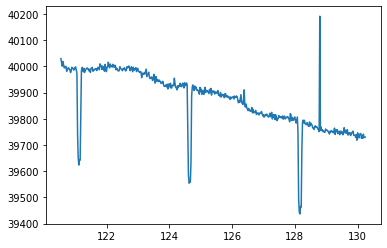

In [12]:
#plt.plot(X, y)
#plt.plot(X, y_pred, color = 'red')
r = y - y_pred # Flattening the graph
plt.plot(X, y)
plt.savefig("./unflattened.pdf")
#plt.plot(X, y_pred, color='red')

In [13]:
a = [i for i in range(len(X)) if X[i]<125.6 and X[i]>123.5] #For Zooming in a portion of graph

In [14]:
F = mean1 = y.mean()  # Calculating mean

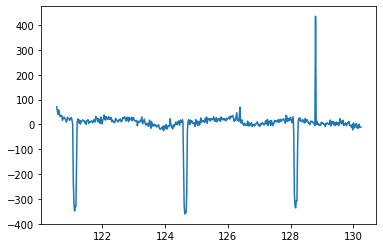

In [15]:
plt.plot(X, r) # Plotting Flattened graph
plt.savefig("flattened.pdf")

In [16]:
r.mean()

-1.2020558811897456e-09

In [17]:
model = bls(x, r)

In [18]:
pgm = model.autopower(0.02)

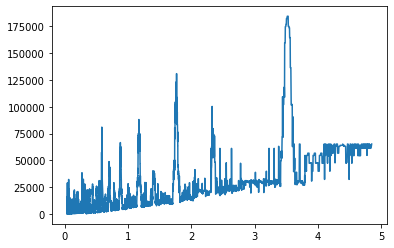

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(pgm.period, pgm.power)
plt.show()
plt.savefig("bls.pdf")

In [20]:
max_power = np.argmax(pgm.power)
stats = model.compute_stats(pgm.period[max_power], pgm.duration[max_power], pgm.transit_time[max_power])

In [21]:
period = pgm.period[max_power]

In [22]:
pgm.transit_time[max_power] 

1.493470772825595

In [23]:
transits = stats['transit_times']

In [24]:
phase = [(p - X[0])%period for p in X] #Creating phase ( For folding periods)
sorte = np.argsort(np.array(phase), axis = None) #Sorted indices

In [25]:
#If phase time are repeated (Not specifically required in this file, but is a necessary step for making model)
ps = [phase[i] for i in sorte]
fp = [r[i] for i in sorte]
fm = []
pnr = [ps[0]]
s = fp[0]
count = 1
for i in range(1, len(ps)):
    if ps[i]==ps[i-1]:
        count+=1
        s+=fp[i]
    else:
        fm.append(s/count)
        count=1
        s = fp[i]
        pnr.append(ps[i])

In [26]:
l = [] #Sorted phase
m = [] #Folded Flux
for x in sorte:
    l.append(phase[x])
    m.append(r[x])
e = [i for i in range(len(l)) if l[i]<0.8 and l[i]>0.44] #For Zooming in the transit period
d = pd.DataFrame({'phase': l[e[0]:e[-1]], 'flux': m[e[0]:e[-1]]})
#d #Printing

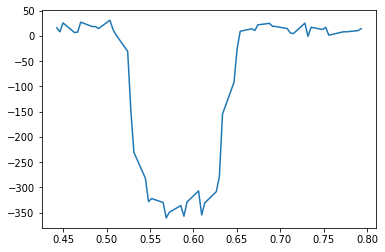

In [27]:
plt.plot(l[e[0]:e[-1]], m[e[0]:e[-1]])#The Folded Lightcurve zoomed in at the transit
plt.savefig("ZoomedOnTransit.pdf")

In [28]:
tf = -0.5036758779260913 + 0.6539004857622785 #Total Transit Time
tt = 0.6298758419989201 - 0.5312941339216195 #Time of full transit
delta = 354.063446/mean1 #Dip/mean
semi = R_s*((2*period/np.pi)*((delta)**0.25)/((tf*tf-tt*tt)**0.5))#Calculating Semi MAjor Axis

In [40]:
tf

0.1502246078361873

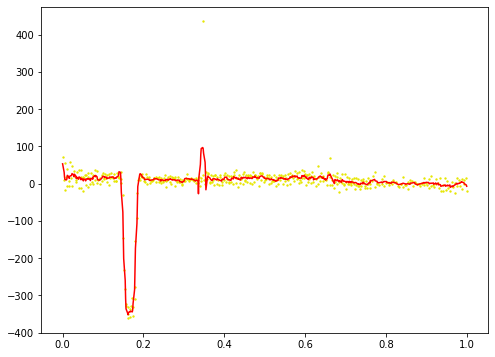

In [29]:
flcf = savgol_filter(m, 11, 3) #Model for the folded lightcurve
plt.scatter(l/period, m, s=2, color = (0.9, 0.9, 0, 0.9)) #Complete Folded Lightcurve after scaling the phase between 0 and 1
plt.plot(l/period, flcf, color = 'red') #Plot of the model
plt.gcf().set_size_inches(8, 6)
plt.savefig("Folded.pdf")

In [30]:
semiau = (semi*695510)/(149597871)# Semi-Major Axis in Astonomical Unit

In [31]:
semiau

0.040919109379812156

In [32]:
period

3.5183036261541827

In [33]:
tt

0.0985817080773006

In [34]:
#Impact Parameter Calculation
alpha = tt/tf
b = ((((1-delta**0.5)**2) - alpha*alpha*((1+delta**0.5)**2))/(1-alpha**2))**0.5

In [35]:
inclination = (np.arccos(b*R_s/semi)/np.pi)*180 #The Inclination of the orbit of the planet wrt Kepler's plane of sight

In [36]:
inclination

83.07201549820206

In [38]:
delta

0.00888001017379896

In [37]:
delF = stats['depth'][0]
delF

350.7480313365093

In [35]:
R_s = 1.486

In [36]:
R_p = R_s*(np.sqrt(delF/F))

In [37]:
R_p/0.100517895#Radius of the planet in units of the radius of jupiter

1.386561799488476

In [38]:
k = period*24*3600
G = 6.674*(10**(-11))
M_s = (semiau**3)*4*(np.pi**2)/(k*k*G)
M_s*(149597871000)**3/(2*10**30)  #Error in some units actual ans 1.213 times

0.7341827534216645

In [40]:
inverse = ifft(fourier)

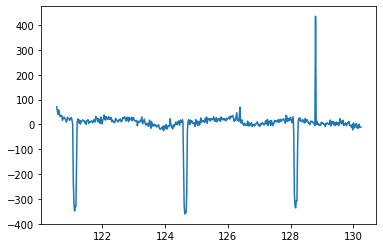

In [41]:
plt.plot(X, inverse)